THE NEURAL NETWORK:
1. The neural network structure: Input layer, one hidden layer, output layer.
2. When initializing the neural network, the user must be able to set the following variables dynamically (through code – no interface needed):

    • Learning rate

    • Momentum
    
    • Number of hidden nodes

In [32]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


class NeuralNetwork():
    def __init__(self, learning_rate, momentum, hidden_nodes, in_nodes, out_nodes, debug):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.hidden_nodes = hidden_nodes
        self.in_nodes = in_nodes  # @ in our data set is 30 features
        self.out_nodes = out_nodes  # @ one output node
        self.debug = debug
        # ? created the randomized weights
        self.ih_weights = np.random.RandomState(
            2).randn(self.in_nodes, self.hidden_nodes)
        self.ho_weights = np.random.RandomState(
            2).randn(self.hidden_nodes, self.out_nodes)

        self.bias_ih = np.zeros((1, self.hidden_nodes))
        self.bias_ho = np.zeros((1, 1))
        # ? initialize z vectors
        # (30,hidden)
        self.z_vector_ih = np.zeros((self.in_nodes, self.hidden_nodes))
        self.z_vector_ho = np.zeros((self.hidden_nodes, self.out_nodes))

        self.z_vector_bias_ih = np.zeros((1, self.hidden_nodes))
        self.z_vector_bias_ho = np.zeros((1, 1))
        # self.ih_weights = None
        # self.ho_weights = None

        # self.z_vector_ih = None
        # self.z_vector_ho = None
        # self.z_vector_bias_ih = None
        # self.z_vector_bias_ho = None
        # self.bias_ih = None
        # self.bias_ho = None
        self.hidden_results = None  # hidden layer values
        self.train_loss = []
        self.pred_loss = []

    def threshold(self, x):
        if x > 0.5:
            return 1
        else:
            return 0

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def loss(self, output, y):
        return np.mean(1/2 * (output - y)**2)
        # predict is responsible for performing a single prediction (classification)
        # using the trained neural network.

    """
    predict is responsible for performing a single prediction (classification) using the trained
    neural network.
    """

    def predict(self, X):
        th = np.vectorize(self.threshold)
        # perform a forward step and return the predicted output
        output = self.forward(X.reshape(1, X.shape[0]))  # reshape x to (1,30)
        return th(output)  # return the output in terms of classes

    """
    fit is responsible for training the neural network where X are the input patterns along with
    their expected labels (y), and epochs in the number of iterations for training the neural network
    print(y)
    """

    def fit(self, X, y, epochs, xtest, ytest):

        if self.debug == True:
            print('Input nodes: ', self.in_nodes,
                  ' Output nodes: ', self.out_nodes, " x shape 0: ", X.shape[0], " y shape 0: ", y.shape[0])

        if self.debug == True:
            print('Weights Shape: ', self.ih_weights.shape, self.ho_weights.shape)
            print('Z vector weights Shape: ',
                  self.z_vector_ih.shape, self.z_vector_ho.shape)
            # print('Bias weights Shape: ', self.bias_ih.shape, self.bias_ho.shape)

        train_reps = X.shape[0]
        test_reps = xtest.shape[0]
        # print(train_reps, test_reps)
        # for each epoch do
        for epoch in range(epochs):
            trloss = 0
            tsloss = 0
            # ?train
            for i in range(train_reps):
                xi = X[i].reshape(1, X[i].shape[0])
                yi = y[i].reshape(y[i].shape[0], 1)
                output = self.forward(xi)  # perform feed forward
                # call back propagetion function
                # loss = self.backward(X[i], y[i], output)
                trloss += self.backward(xi, yi, output)
            trloss = trloss/train_reps
            self.train_loss.append(trloss)

            # ?test/validation
            for i in range(test_reps):
                xi = xtest[i].reshape(1, xtest[i].shape[0])
                yi = ytest[i].reshape(ytest[i].shape[0], 1)
                output = self.forward(xi)
                tsloss += self.loss(output, yi)

            tsloss = tsloss/test_reps
            self.pred_loss.append(tsloss)

            if self.debug == True:
                print(' ===> Epoch: %d ' % epoch, 'Train loss: ',
                      trloss, '--', ' Test Loss: ', tsloss)

    """
    forward is responsible for the feed forward functionality of the
    neural network, where X is the input pattern.
    """

    def forward(self, X):

        sg = np.vectorize(self.sigmoid)  # sigmoid activation function

        # ?input to hidden layer calculation
        # multiply weights with input to get hidden
        self.hidden_results = np.dot(X, self.ih_weights) + self.bias_ih
        # print(self.hidden_results.shape)
        # apply sigmoid to hidden layer
        self.hidden_results = sg(self.hidden_results)

        # ?hidden to output layer calculation
        # multiply hidden with weights to get output 𝑎1 = φ(Θ1,0 + Θ1,1 *𝑎1 + ..)
        output = np.dot(self.hidden_results, self.ho_weights) + self.bias_ho

        # final activation function, apply sigmoid to output
        output = sg(output)
        # print(output.shape)
        return output

    """
    backward is responsible for running the back propagation functionality of the neural network.
    Here you should implement stochastic gradient descent (SGD) and update the network
    weights accordingly. X is the input pattern,
    y is the expected output and output is the calculated output.
    print(X.shape, y.shape, output.shape)
    """

    def backward(self, X, y, output):
        # sigmoid derivative function
        sgp = np.vectorize(self.sigmoid_derivative)

        # ?compute output layer error and delta  a*(1-a)*(a-y)
        output_error = output-y  # calculate output error (a-y)
        output_delta = sgp(output)*output_error

        # ? calculate hidden layer delta
        hidden_delta = sgp(self.hidden_results)*np.dot(
            output_delta, self.ho_weights.T)

        # ? update input to hidden layer weights adding momentum
        gradient = X.T.dot(hidden_delta)  # X.T.dot(hidden_delta)  # (δi*xi)
        self.z_vector_ih = np.add(
            (self.momentum*self.z_vector_ih), gradient)  # zt=μ*z(t-1)+gradient
        self.ih_weights -= (self.z_vector_ih*self.learning_rate)

        # ? update hidden layer to output weights adding momentum
        # print(self.hidden_results.shape)
        gradient = np.dot(self.hidden_results.T, output_delta)  # (δi*ai)
        self.z_vector_ho = np.add(
            (self.momentum*self.z_vector_ho), gradient)  # zt=μ*z(t-1)+gradient
        self.ho_weights -= (self.z_vector_ho*self.learning_rate)

        # ? update input to hidden layer BIAS weights with momentum
        # ? for bias gradient is just the hidden delta as node value is 1
        # print(hidden_delta.shape, output_delta.shape)
        self.z_vector_bias_ih = np.add(
            (self.momentum*self.z_vector_bias_ih), hidden_delta)
        self.bias_ih -= (self.learning_rate * self.z_vector_bias_ih)

        # ? update hidden layer to output BIAS weights with momentum
        # ? for bias gradient is just the output delta as node value is 1
        self.z_vector_bias_ho = np.add(
            (self.momentum*self.z_vector_bias_ho), output_delta)
        self.bias_ho -= (self.learning_rate*self.z_vector_bias_ho)

        return np.mean(1/2 * (output_error)**2)  # output-y

    def plot_train_test_loss(self):
        # plot the graph
        plt.title("Training VS Test Loss with learning rate: " + str(
            self.learning_rate)+" ,momentum: " + str(self.momentum)
            + ",hidden nodes: "+str(self.hidden_nodes))
        plt.xlabel("Number of Epochs")
        plt.ylabel("Loss Value")

        trainlen = len(self.train_loss)
        epochs = np.arange(0, trainlen, 1).tolist()

        plt.plot(epochs, self.train_loss,
                 color='BLUE', label="Training Loss")
        plt.plot(epochs, self.pred_loss,
                 color='RED', label="Test Loss")
        plt.legend(loc=1)
        plt.grid(True)
        plt.show()

    def accuracy(self, X_test, y_test):
        predict_out = []
        for i in range(X_test.shape[0]):
            predict_out.append(self.predict(X_test[i])[0][0])
        predict_out = np.asarray(predict_out)
        predict_out = predict_out.reshape(predict_out.shape[0], 1)
        return accuracy_score(y_test, predict_out)



Task B:
For this task you need to train a classifier on the breast cancer dataset, perform some
experiments and analyse/explain your results.


In [25]:
import numpy as np
import importlib
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import warnings
# from NeuralNetwork import NeuralNetwork
from sklearn.model_selection import RandomizedSearchCV
warnings.filterwarnings('ignore')

bc = datasets.load_breast_cancer()
X, y = bc.data, bc.target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=0)
y_test = y_test.reshape(y_test.shape[0], 1)
y_train = y_train.reshape(y_train.shape[0], 1)
in_nodes=X_train.shape[1]
out_nodes=y_train.shape[1]

B.1: Make sure you reset / recreate your models for each task.
Train your neural network on the breast cancer data using the following settings:

• learning_rate = 0.0001

• momentum = 0

• hidden_nodes = 256

• epochs = 1400

1. Plot the average train and test loss on the same graph for each learning epoch (1400).
2. Compare the two charts, do you notice any problem? 
3. What could you do to fix it? 

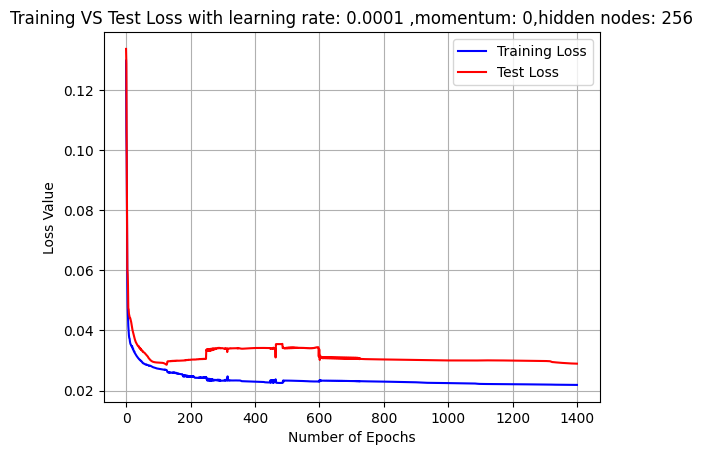

In [26]:
nn=NeuralNetwork(0.0001,0,256,in_nodes,out_nodes,False)
nn.fit(X_train,y_train,1400,X_test,y_test)
nn.plot_train_test_loss()

B.2.1 Learning Rate Experiments

Settings:

• Momentum: 0

• Nodes in hidden layer: 32

• Epochs: 250

Using the above settings, for each the following learning rates: [0.0001,0.001,0.01,0.1,1]
train the neural network and:
1. Plot a line chart of the average train/test loss during training (250 iterations).
2. Print the final training loss of the neural network.
3. Calculate the accuracy of the neural network on the test set.
4. Plot a line chart of the final training loss for each learning rate (x axis).
5. Plot a line chart of the accuracy of the neural network for each learning rate (x axis).

Comment on your results (charts and metrics). What do you notice? Explain your findings.

Learning rate:  0.0001


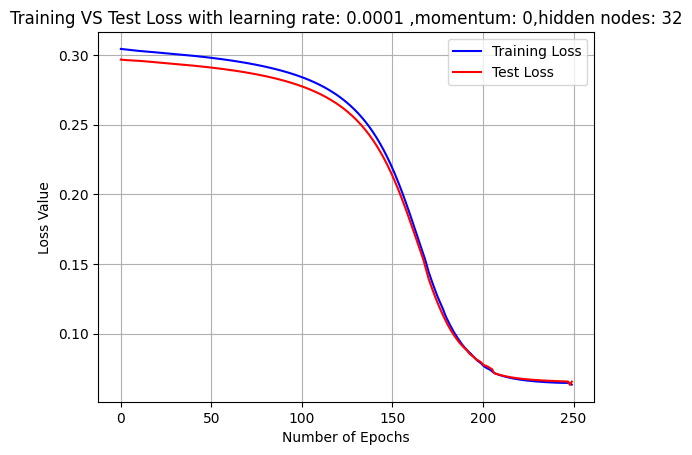

Final training loss:  0.06341052397606561
Accuracy:  0.8947368421052632
Learning rate:  0.001


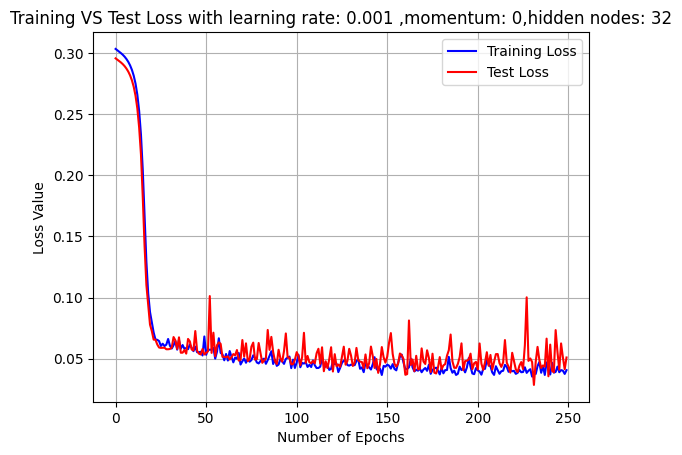

Final training loss:  0.040576911750931206
Accuracy:  0.8596491228070176
Learning rate:  0.01


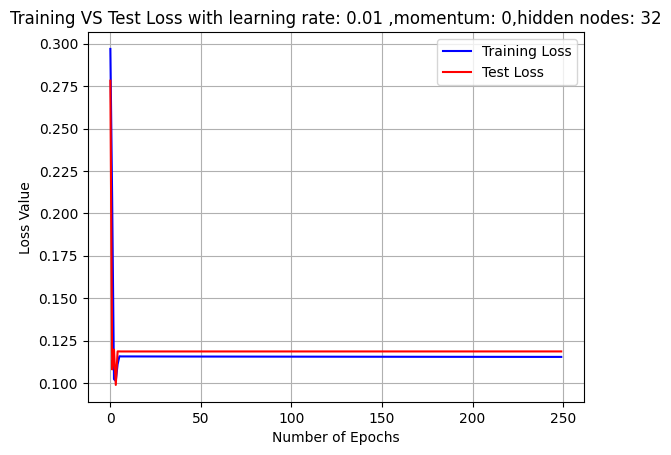

Final training loss:  0.11533249845725961
Accuracy:  0.6140350877192983
Learning rate:  0.1


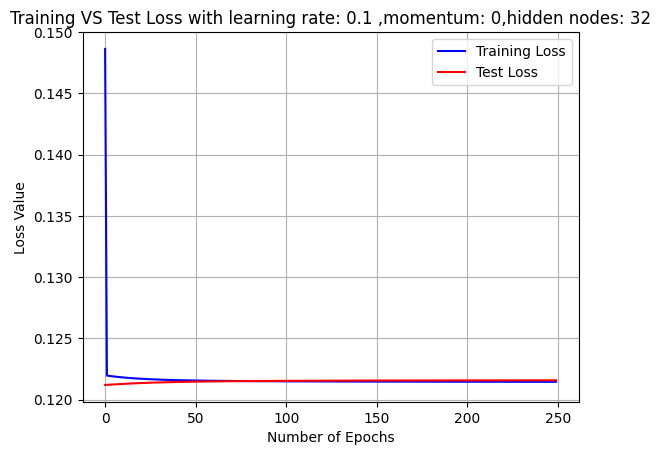

Final training loss:  0.12144533916254972
Accuracy:  0.6140350877192983
Learning rate:  1


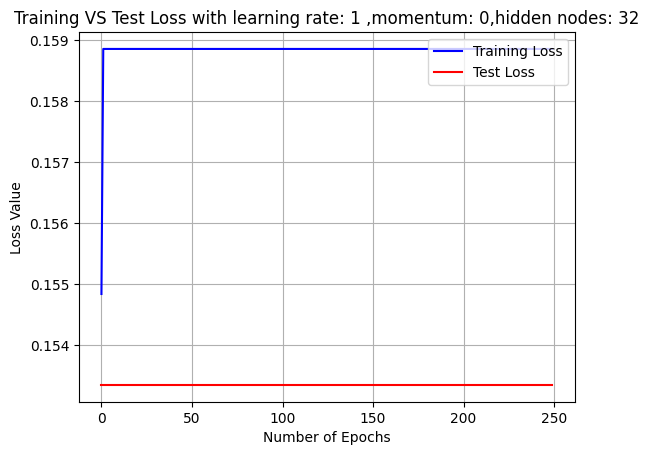

Final training loss:  0.15885593054244387
Accuracy:  0.6140350877192983


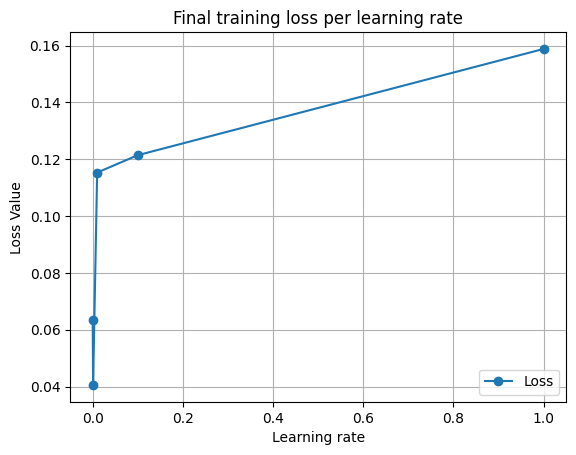

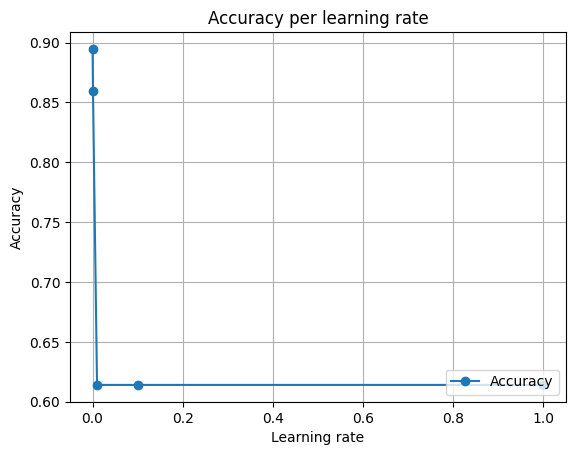

In [27]:
f_training=[]
lr_accuracy=[]

# print(epochs)
for learning_rt  in [0.0001,0.001,0.01,0.1,1]:
    print("Learning rate: ",learning_rt)
    nn=NeuralNetwork(learning_rt,0,32,in_nodes,out_nodes,False)
    nn.fit(X_train,y_train,250,X_test,y_test)
    nn.plot_train_test_loss() #plot train vs test 
    
    final_loss=nn.train_loss[len(nn.train_loss)-1] 
    print("Final training loss: ",final_loss) #get final training loss
    acc=nn.accuracy(X_test,y_test)
    print('Accuracy: ',acc)
    
    
    
    f_training.append(final_loss)
    lr_accuracy.append(acc)
# print(f_training,lr_accuracy)
plt.title("Final training loss per learning rate")
plt.xlabel("Learning rate")
plt.ylabel("Loss Value")
plt.plot([0.0001,0.001,0.01,0.1,1],f_training,label="Loss",marker='o')
plt.legend(loc=4)
plt.grid(True)
plt.show()

plt.title("Accuracy per learning rate")
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.plot([0.0001,0.001,0.01,0.1,1],lr_accuracy,label="Accuracy",marker='o')
plt.legend(loc=4)
plt.grid(True)
plt.show()

B.2.2 Hidden Layer Nodes Experiments

Settings:

• Learning rate: 0.0001

• Momentum: 0

• Epochs: 250

Using the above settings, for each the following number of nodes in the hidden layer:
[8,16,32,64,128,256,512], train the neural network and:

6. Plot a line chart of the average train/test loss during training (250 iterations).
7. Print the final training loss of the neural network.
8. Calculate the accuracy of the neural network on the test set.
9. Plot a line chart of the final training loss for each number of nodes (x axis).
10. Plot a line chart of the accuracy of the neural network for each number of nodes (x
axis).

Comment on your results (charts and metrics). What do you notice? Explain your findings.


Hidden nodes number:  8


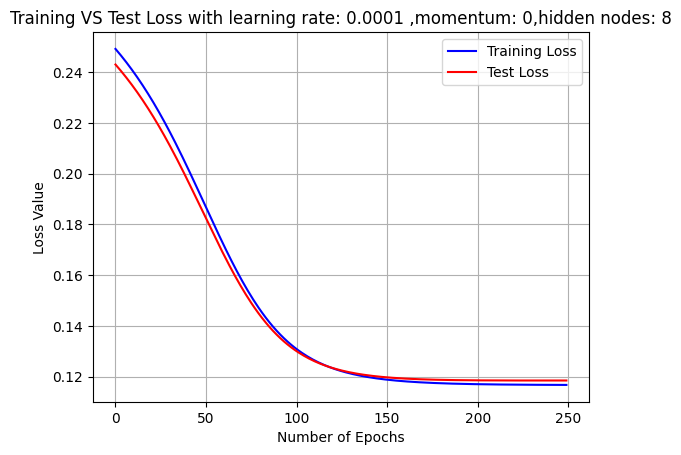

Final training loss:  0.11675990399729347
Accuracy:  0.6140350877192983
Hidden nodes number:  16


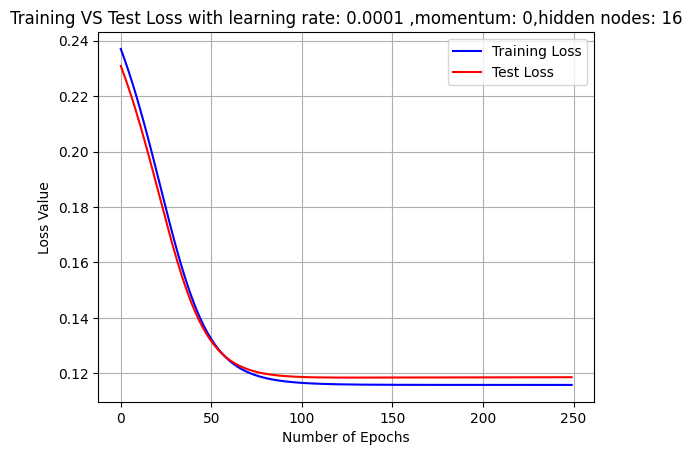

Final training loss:  0.11585422534738381
Accuracy:  0.6140350877192983
Hidden nodes number:  32


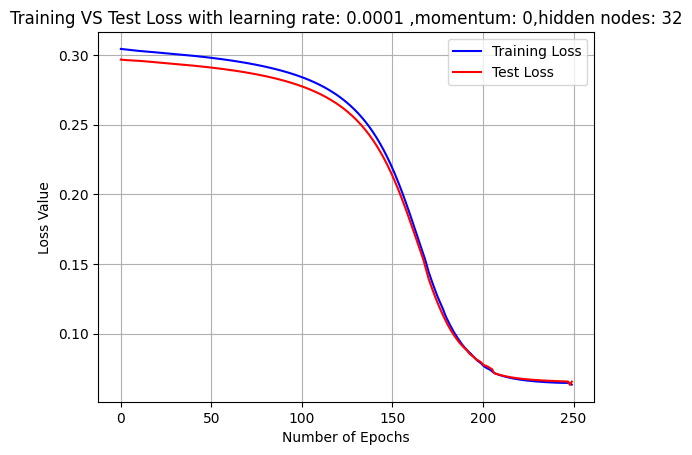

Final training loss:  0.06341052397606561
Accuracy:  0.8947368421052632
Hidden nodes number:  64


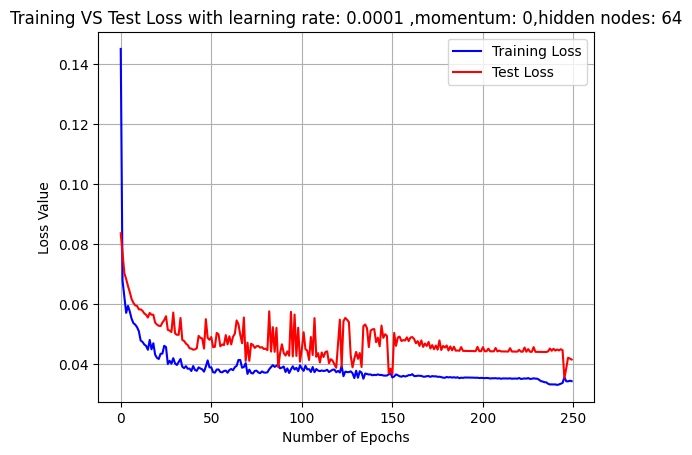

Final training loss:  0.03430732683022814
Accuracy:  0.9122807017543859
Hidden nodes number:  128


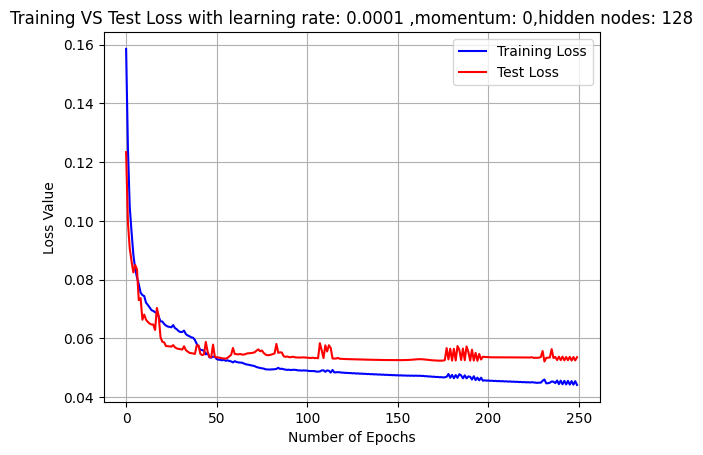

Final training loss:  0.044099596352357225
Accuracy:  0.8771929824561403
Hidden nodes number:  256


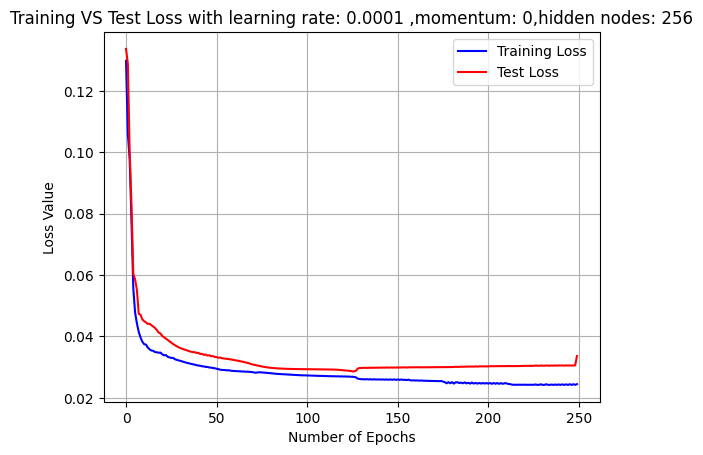

Final training loss:  0.02444852665621619
Accuracy:  0.9122807017543859
Hidden nodes number:  512


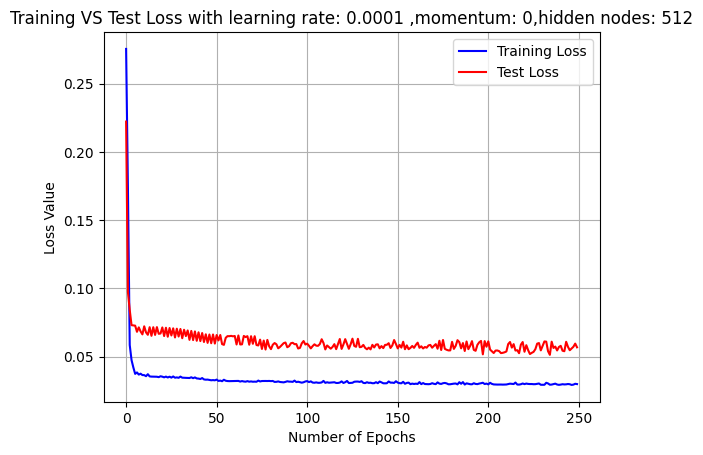

Final training loss:  0.029935629715706718
Accuracy:  0.8596491228070176


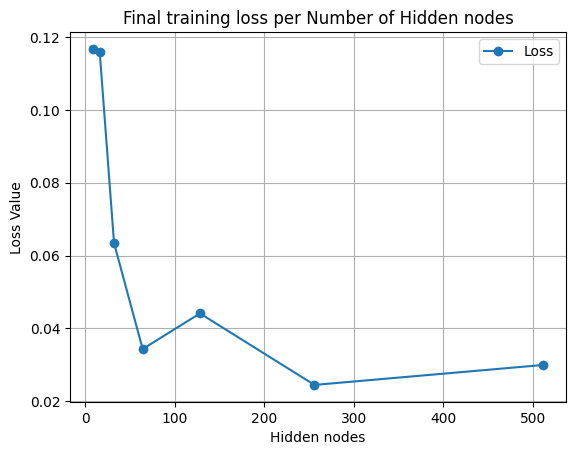

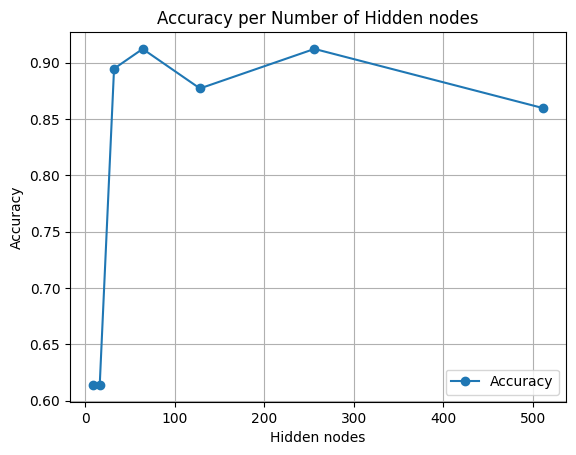

In [28]:
f_training=[]
lr_accuracy=[]
for hidden_nodes  in [8,16,32,64,128,256,512]:
    print("Hidden nodes number: ",hidden_nodes)
    nn=NeuralNetwork(0.0001,0,hidden_nodes,in_nodes,out_nodes,False)
    nn.fit(X_train,y_train,250,X_test,y_test)
    nn.plot_train_test_loss() #plot train vs test for learning rate i
    
    final_loss=nn.train_loss[len(nn.train_loss)-1] 
    print("Final training loss: ",final_loss) #get final training loss
    acc=nn.accuracy(X_test,y_test)
    print('Accuracy: ',acc)
    
   
    
    f_training.append(final_loss)
    lr_accuracy.append(acc)
    
plt.title("Final training loss per Number of Hidden nodes")
plt.xlabel("Hidden nodes")
plt.ylabel("Loss Value")
plt.plot([8,16,32,64,128,256,512],f_training,label="Loss",marker='o')
plt.legend(loc=1)
plt.grid(True)
plt.show()

plt.title("Accuracy per Number of Hidden nodes")
plt.xlabel("Hidden nodes")
plt.ylabel("Accuracy")
plt.plot([8,16,32,64,128,256,512],lr_accuracy,label="Accuracy",marker='o')
plt.legend(loc=4)
plt.grid(True)
plt.show()

B.2.3 Momentum Experiments

Settings:

• Learning rate: 0.001

• Nodes in hidden layer: 32

• Epochs: 250

Using the above settings, for each the following momentum values: [0, 0.1, 0.25, 0.5,1], train
the neural network and:

11. Plot a line chart of the average train/test loss during training (250 iterations).
12. Print the final training loss of the neural network.
13. Calculate the accuracy of the neural network on the test set.
14. Plot a line chart of the final training loss for each momentum (x axis).
15. Plot a line chart of the accuracy of the neural network for each momentum (x axis).

Comment on your results (charts and metrics). 
What do you notice? Explain your findings.

Note: Normally for the tasks above you should also create a validation set, but for the
purpose of this assignment we only use the test set.

Momentum:  0


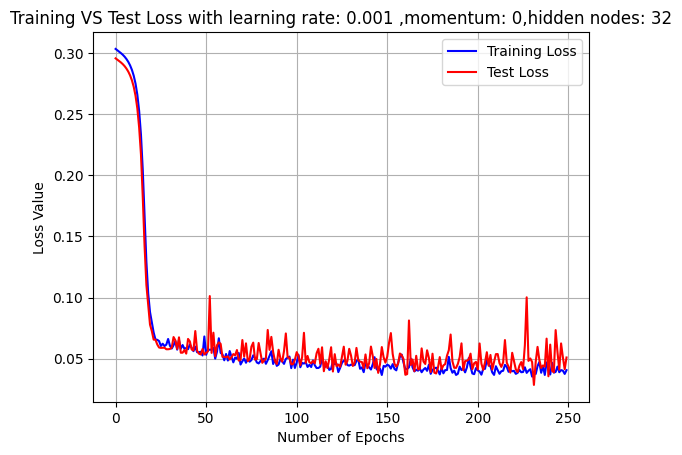

Final training loss:  0.040576911750931206
Accuracy:  0.8596491228070176
Momentum:  0.1


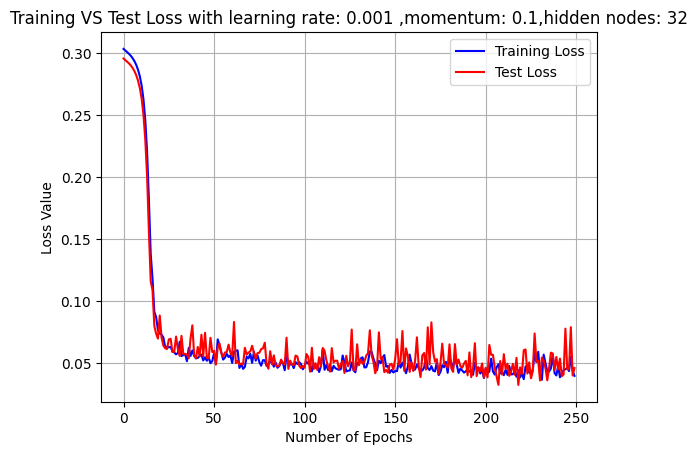

Final training loss:  0.03962640770241923
Accuracy:  0.9122807017543859
Momentum:  0.25


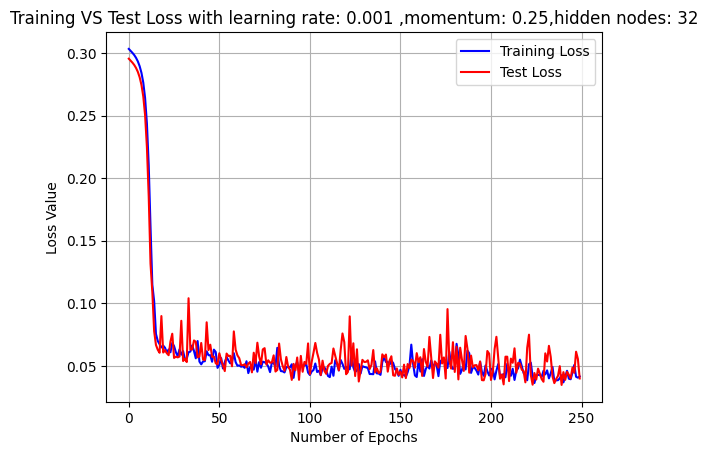

Final training loss:  0.04160312659284159
Accuracy:  0.8771929824561403
Momentum:  0.5


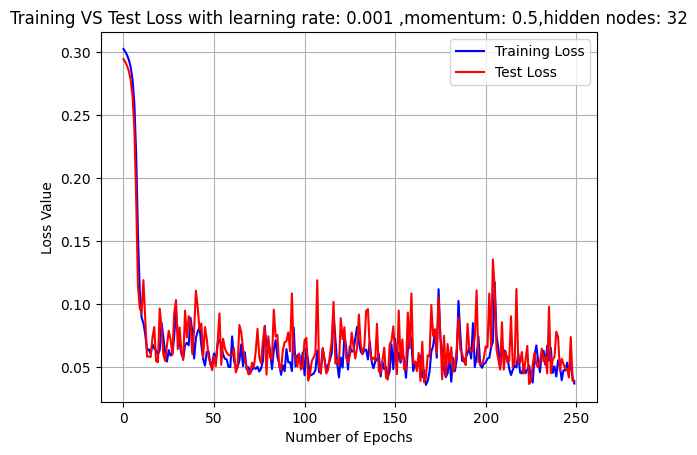

Final training loss:  0.03722892991205294
Accuracy:  0.9122807017543859
Momentum:  1


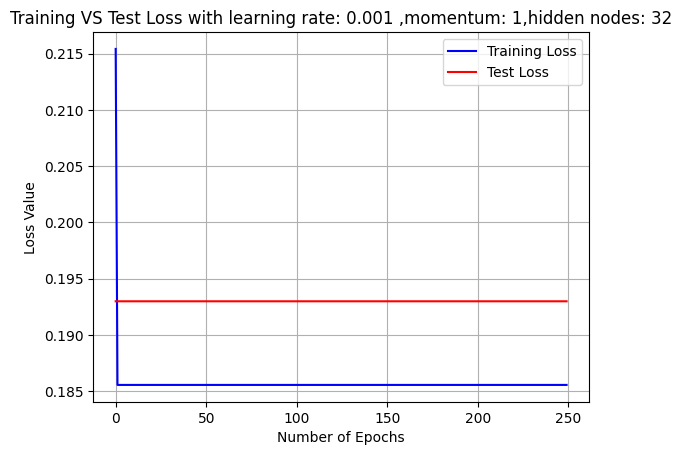

Final training loss:  0.185546875
Accuracy:  0.6140350877192983


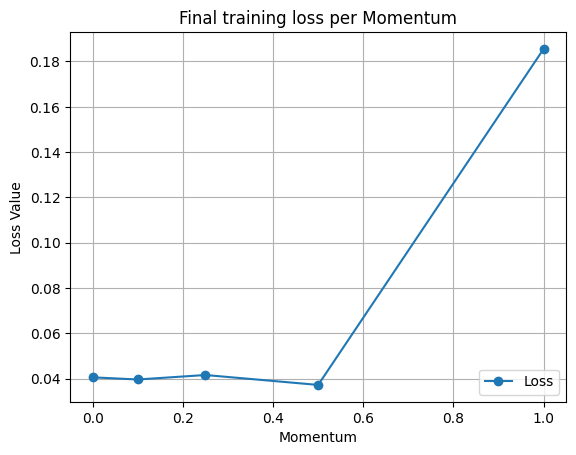

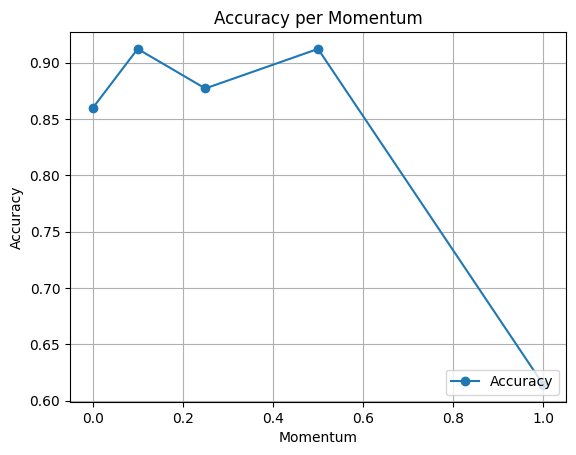

In [29]:
f_training=[]
lr_accuracy=[]
for momentum  in [0, 0.1, 0.25, 0.5,1]:
    print("Momentum: ",momentum)
    nn=NeuralNetwork(0.001,momentum,32,in_nodes,out_nodes,False)
    nn.fit(X_train,y_train,250,X_test,y_test)
    nn.plot_train_test_loss() #plot train vs test 
    
    final_loss=nn.train_loss[len(nn.train_loss)-1] 
    print("Final training loss: ",final_loss) #get final training loss
    acc=nn.accuracy(X_test,y_test)
    print('Accuracy: ',acc)
    
    
    
    f_training.append(final_loss)
    lr_accuracy.append(acc)
    
plt.title("Final training loss per Momentum")
plt.xlabel("Momentum")
plt.ylabel("Loss Value")
plt.plot([0, 0.1, 0.25, 0.5,1],f_training,label="Loss",marker='o')
plt.legend(loc=4)
plt.grid(True)
plt.show()

plt.title("Accuracy per Momentum")
plt.xlabel("Momentum")
plt.ylabel("Accuracy")
plt.plot([0, 0.1, 0.25, 0.5,1],lr_accuracy,label="Accuracy",marker='o')
plt.legend(loc=4)
plt.grid(True)
plt.show()

B.2.4 Final Neural Network – Hyperparameter finetuning

Select the learning rate, momentum and number of nodes in the hidden layer that yield the
highest accuracy after training for 250 epochs. You can use the above value ranges for your
network’s setting experiments (model selection), or you can choose entirely new
combinations. You can use any method you want (manual grid, grid search, random search
etc). You can use the pre-made train/test splits like the above tasks (no need for validation
set) or you can split the dataset (X, y) however else you like (e.g., to include validation
sets/folds).

• Visualize the accuracy of each hyperparameter combination on a table or chart, and
select the best combination based on accuracy.

• For the best hyperparameter combination

    o Plot a line chart of the average train/test loss during training (250 iterations).

    o Print the final training loss of the neural network.
    
    o Print the accuracy of the neural network on the test set.

In [30]:
from tabulate import tabulate #pip install tabulate
print('Hyperparameter tuning...')
# momentum=[0, 0.1]
# learning_rate=[0.0001]
# hidden_nodes=[256]

# momentum=[0, 0.1, 0.25, 0.9]
# learning_rate=[0.0001,0.001,0.01,0.1,1]
# hidden_nodes=[64,128,256,512]

momentum=[0, 0.1, 0.25, 0.5,0.9]
learning_rate=[0.0001,0.001,0.01,0.1,1]
hidden_nodes=[8,16,32,64,128,256,512]

def sort_key(score):
  return score[3]

data=[]
col_names=['Learning rate','Hidden nodes','Momentum','Accuracy']

# best_parameters={'Learning rate':0,
#                  'Hidden nodes':0,
#                  'Momentum':0,
#                  'Accuracy':0
#                  }

for lr in learning_rate:
    for hn in hidden_nodes:
          for m in momentum:
            nn=NeuralNetwork(lr,m,hn,in_nodes,out_nodes,False)
            nn.fit(X_train,y_train,250,X_test,y_test)
            acc=nn.accuracy(X_test,y_test)
            data.append([lr,hn,m,acc])
            # if best_parameters['Accuracy']<acc:
            #     best_parameters['Learning rate']=lr
            #     best_parameters['Hidden nodes']=hn
            #     best_parameters['Momentum']=m
            #     best_parameters['Accuracy']=acc
            
data.sort(key=sort_key,reverse=True)
print(tabulate(data, headers=col_names))
# print('Best parameters:')
# print(best_parameters)

Hyperparameter tuning...
  Learning rate    Hidden nodes    Momentum    Accuracy
---------------  --------------  ----------  ----------
         0.0001             256        0.25    0.964912
         0.001               64        0.25    0.947368
         0.001              512        0.1     0.947368
         0.0001              64        0.1     0.929825
         0.0001             256        0.5     0.929825
         0.0001             256        0.9     0.929825
         0.001              256        0       0.929825
         0.001              256        0.1     0.929825
         0.0001              32        0.25    0.912281
         0.0001              32        0.9     0.912281
         0.0001              64        0       0.912281
         0.0001              64        0.9     0.912281
         0.0001             128        0.9     0.912281
         0.0001             256        0       0.912281
         0.0001             256        0.1     0.912281
         0.001         

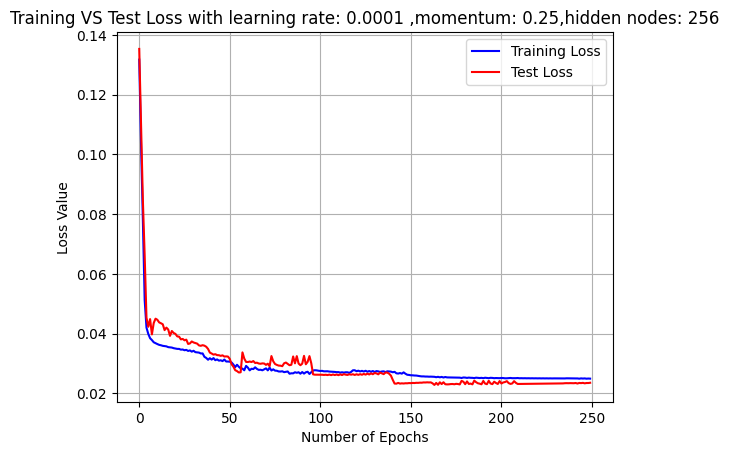

Final training loss:  0.02494345937128505
Accuracy:  0.9649122807017544


In [5]:
#use best parameters to create the neural network choose one fo the parameters that yield the highest score
#  Learning         Hidden     Momentum  Accuracy
# 	rate           nodes
# 0.0001             256        0       0.947368
# 0.0001             256        0.9     0.947368
# 0.001              256        0       0.947368
# 0.001              256        0.25    0.947368

nn=NeuralNetwork(0.0001,0.25,256,in_nodes,out_nodes,False)
nn.fit(X_train,y_train,250,X_test,y_test)
nn.plot_train_test_loss() #plot train vs test for the best parameters

final_loss=nn.train_loss[len(nn.train_loss)-1] 
print("Final training loss: ",final_loss) #get final training loss
acc=nn.accuracy(X_test,y_test)
print('Accuracy: ',acc)

